In [34]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import deeplake
import timm
import matplotlib.pyplot as plt

from torchvision import transforms
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, roc_auc_score
from tqdm.auto import tqdm

# reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


-

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-train



-

hub://activeloop/nih-chest-xray-train loaded successfully.



\

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/nih-chest-xray-test



|

hub://activeloop/nih-chest-xray-test loaded successfully.



Available tensors: ['findings', 'images', 'metadata/follow_up_num', 'metadata/orig_img_h', 'metadata/orig_img_pix_spacing_x', 'metadata/orig_img_pix_spacing_y', 'metadata/orig_img_w', 'metadata/patient_age', 'metadata/patient_gender', 'metadata/patient_id', 'metadata/view_position']


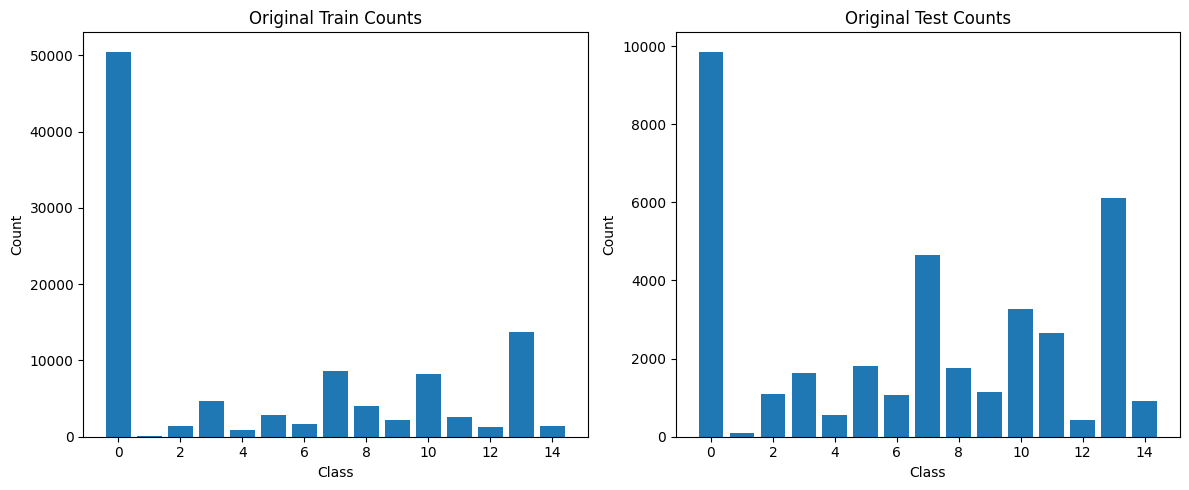

In [35]:
ds_train = deeplake.load('hub://activeloop/nih-chest-xray-train')
ds_test  = deeplake.load('hub://activeloop/nih-chest-xray-test')
print("Available tensors:", list(ds_train.tensors.keys()))

label_field = 'findings'
n_classes   = 15

def get_class_counts(ds, field, n):
    cnt = np.zeros(n, int)
    for lbl in ds[field].numpy(aslist=True):
        for c in lbl:
            cnt[int(c)] += 1
    return cnt

train_counts = get_class_counts(ds_train, label_field, n_classes)
test_counts  = get_class_counts(ds_test,  label_field, n_classes)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.bar(range(n_classes), train_counts)
plt.title("Original Train Counts")
plt.xlabel("Class"); plt.ylabel("Count")
plt.subplot(1,2,2)
plt.bar(range(n_classes), test_counts)
plt.title("Original Test Counts")
plt.xlabel("Class"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

In [36]:
def drop_class_zero(ds, drop_n, field='findings'):
    idx0 = [i for i, lbl in enumerate(ds[field].numpy(aslist=True)) if 0 in lbl]
    drop = set(random.sample(idx0, drop_n))
    keep = [i for i in range(len(ds)) if i not in drop]
    return ds[keep]

ds_train_pruned = drop_class_zero(ds_train, 45000, label_field)
ds_test_pruned  = drop_class_zero(ds_test,  5000,  label_field)

print(f"Pruned train: {len(ds_train_pruned)} samples")
print(f"Pruned test:  {len(ds_test_pruned)} samples")

Pruned train: 41524 samples
Pruned test:  20596 samples


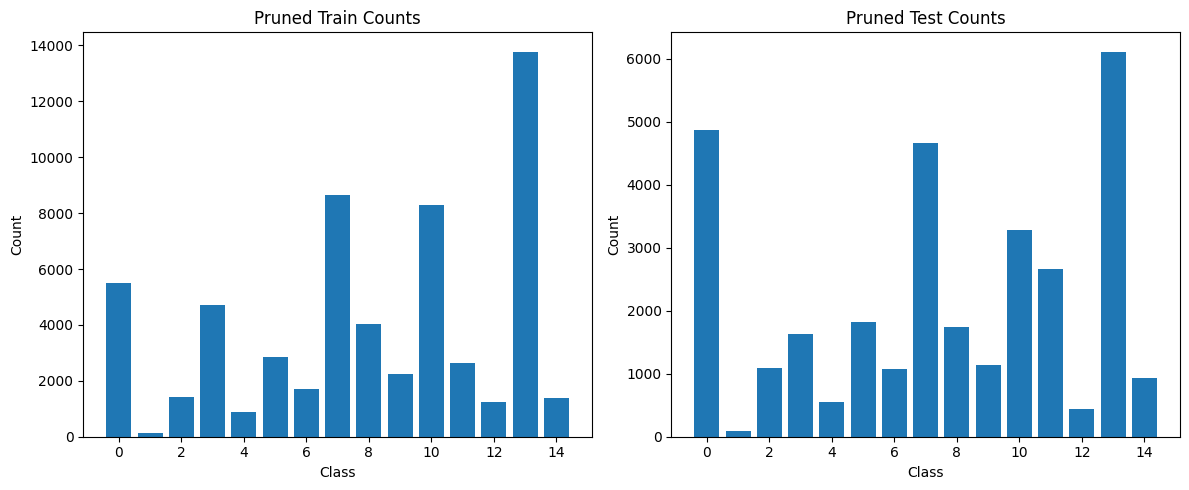

In [37]:
train_pruned = get_class_counts(ds_train_pruned, label_field, n_classes)
test_pruned  = get_class_counts(ds_test_pruned,  label_field, n_classes)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.bar(range(n_classes), train_pruned)
plt.title("Pruned Train Counts")
plt.xlabel("Class"); plt.ylabel("Count")
plt.subplot(1,2,2)
plt.bar(range(n_classes), test_pruned)
plt.title("Pruned Test Counts")
plt.xlabel("Class"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

In [38]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

def get_loader(ds, cls, batch_size=32, shuffle=True):
    def collate_fn(batch):
        imgs = torch.stack([transform(item['images']) for item in batch])
        labs = torch.tensor(
            [1.0 if cls in item['findings'] else 0.0 for item in batch],
            dtype=torch.float32
        )
        return imgs, labs

    return ds.pytorch(
        batch_size=batch_size,
        shuffle=shuffle,
        decode_method={"images": "pil"},
        collate_fn=collate_fn,
        num_workers=0
    )

# Sanity check
train_loader0 = get_loader(ds_train_pruned, 0)
print("Batches for class 0:", len(train_loader0))

Batches for class 0: 1298


In [39]:
def create_vit():
    model = timm.create_model('vit_base_patch16_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, 1)
    return model.to(device)

model = create_vit()

In [40]:
loss_fn = nn.BCEWithLogitsLoss()

def train_epoch(model, loader, optimizer):
    model.train()
    losses, probs, trues = [], [], []
    for imgs, labs in tqdm(loader):
        imgs, labs = imgs.to(device), labs.to(device)
        optimizer.zero_grad()
        out = model(imgs).squeeze(1)
        loss = loss_fn(out, labs)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        p = torch.sigmoid(out).detach().cpu().numpy()
        losses.append(loss.item())
        probs.extend(p)
        trues.extend(labs.detach().cpu().numpy())
    return np.mean(losses), np.array(probs), np.array(trues)

def eval_epoch(model, loader):
    model.eval()
    losses, probs, trues = [], [], []
    with torch.no_grad():
        for imgs, labs in loader:
            imgs, labs = imgs.to(device), labs.to(device)
            out = model(imgs).squeeze(1)
            loss = loss_fn(out, labs)
            losses.append(loss.item())
            p = torch.sigmoid(out).detach().cpu().numpy()
            probs.extend(p)
            trues.extend(labs.detach().cpu().numpy())
    return np.mean(losses), np.array(probs), np.array(trues)

In [41]:
def compute_metrics(probs, truths, thresh=0.5):
    preds = (probs >= thresh).astype(int)
    return {
        'acc'     : accuracy_score(truths, preds),
        'f1_micro': f1_score(truths, preds, average='micro'),
        'f1_macro': f1_score(truths, preds, average='macro'),
        'hamming' : hamming_loss(truths, preds),
        'auc'     : roc_auc_score(truths, probs),
    }

def plot_history(hist, title):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(hist['train_loss'], label='train_loss')
    plt.plot(hist['val_loss'],   label='val_loss')
    plt.title(f"{title} Loss"); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(hist['train_acc'], label='train_acc')
    plt.plot(hist['val_acc'],   label='val_acc')
    plt.title(f"{title} Acc"); plt.legend()
    plt.show()


In [42]:
cls = 0
train_loader = get_loader(ds_train_pruned, cls)
val_loader   = get_loader(ds_test_pruned,  cls, shuffle=False)

model     = create_vit()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs    = 5

history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

for ep in range(1, epochs+1):
    t_loss, t_probs, t_lbls = train_epoch(model, train_loader, optimizer)
    v_loss, v_probs, v_lbls = eval_epoch(model, val_loader)

    m_tr = compute_metrics(t_probs, t_lbls)
    m_v  = compute_metrics(v_probs, v_lbls)

    history['train_loss'].append(t_loss)
    history['val_loss'].append(v_loss)
    history['train_acc'].append(m_tr['acc'])
    history['val_acc'].append(m_v['acc'])

    print(f"Epoch {ep}/{epochs} — "
          f"TLoss {t_loss:.3f}, VLoss {v_loss:.3f}, "
          f"TAcc {m_tr['acc']:.3f}, VAcc {m_v['acc']:.3f}, "
          f"F1 {m_v['f1_micro']:.3f}, AUC {m_v['auc']:.3f}")

plot_history(history, title=f"Class {cls}")


 93%|█████████▎| 1204/1298 [2:07:42<18:41, 11.93s/it]  /Users/craigroberts/Documents/Coding/Machine_learning/Chest-X-R-AI/.venv/lib/python3.11/site-packages/deeplake/util/warnings.py:7: UserWarning: Encountered connection error, retry 1 out of 5
  warnings.warn(*args, **kwargs)
/Users/craigroberts/Documents/Coding/Machine_learning/Chest-X-R-AI/.venv/lib/python3.11/site-packages/deeplake/util/warnings.py:7: UserWarning: Connection re-established after 1 retry.
  warnings.warn(*args, **kwargs)
 94%|█████████▍| 1221/1298 [3:46:42<44:44, 34.86s/it]     /Users/craigroberts/Documents/Coding/Machine_learning/Chest-X-R-AI/.venv/lib/python3.11/site-packages/deeplake/util/warnings.py:7: UserWarning: Encountered connection error, retry 1 out of 5
  warnings.warn(*args, **kwargs)
/Users/craigroberts/Documents/Coding/Machine_learning/Chest-X-R-AI/.venv/lib/python3.11/site-packages/deeplake/util/warnings.py:7: UserWarning: Connection re-established after 1 retry.
  warnings.warn(*args, **kwargs)
100

Epoch 1/5 — TLoss 0.400, VLoss 0.588, TAcc 0.866, VAcc 0.764, F1 0.764, AUC 0.620


100%|██████████| 1298/1298 [2:14:56<00:00,  6.24s/it] 


Epoch 2/5 — TLoss 0.383, VLoss 0.602, TAcc 0.868, VAcc 0.764, F1 0.764, AUC 0.626


 66%|██████▋   | 862/1298 [1:56:39<1:04:06,  8.82s/it]/Users/craigroberts/Documents/Coding/Machine_learning/Chest-X-R-AI/.venv/lib/python3.11/site-packages/deeplake/util/warnings.py:7: UserWarning: Encountered connection error, retry 1 out of 5
  warnings.warn(*args, **kwargs)
/Users/craigroberts/Documents/Coding/Machine_learning/Chest-X-R-AI/.venv/lib/python3.11/site-packages/deeplake/util/warnings.py:7: UserWarning: Connection re-established after 1 retry.
  warnings.warn(*args, **kwargs)
100%|██████████| 1298/1298 [3:27:35<00:00,  9.60s/it]    


Epoch 3/5 — TLoss 0.374, VLoss 0.754, TAcc 0.868, VAcc 0.764, F1 0.764, AUC 0.615


 60%|██████    | 785/1298 [1:33:27<4:04:01, 28.54s/it]  /Users/craigroberts/Documents/Coding/Machine_learning/Chest-X-R-AI/.venv/lib/python3.11/site-packages/deeplake/util/warnings.py:7: UserWarning: Encountered connection error, retry 1 out of 5
  warnings.warn(*args, **kwargs)
/Users/craigroberts/Documents/Coding/Machine_learning/Chest-X-R-AI/.venv/lib/python3.11/site-packages/deeplake/util/warnings.py:7: UserWarning: Connection re-established after 1 retry.
  warnings.warn(*args, **kwargs)
 65%|██████▍   | 840/1298 [4:24:31<1:28:32, 11.60s/it]    /Users/craigroberts/Documents/Coding/Machine_learning/Chest-X-R-AI/.venv/lib/python3.11/site-packages/deeplake/util/warnings.py:7: UserWarning: Encountered connection error, retry 1 out of 5
  warnings.warn(*args, **kwargs)
/Users/craigroberts/Documents/Coding/Machine_learning/Chest-X-R-AI/.venv/lib/python3.11/site-packages/deeplake/util/warnings.py:7: UserWarning: Connection re-established after 1 retry.
  warnings.warn(*args, **kwargs)
 6

KeyboardInterrupt: 

In [ ]:
all_metrics = {}
for cls in range(15):
    tr = get_loader(ds_train_pruned, cls)
    vl = get_loader(ds_test_pruned,  cls, shuffle=False)
    m  = create_vit()
    o  = optim.Adam(m.parameters(), lr=1e-4)
    for _ in range(3): train_epoch(m, tr, o)
    vloss, vprobs, vtrues = eval_epoch(m, vl)
    all_metrics[cls] = compute_metrics(vprobs, vtrues)

print("Final one‑vs‑all metrics:", all_metrics)